In [1]:
import osmnx as ox
ox.config(log_console=True, use_cache=True)
import pandas as pd
import geopandas as gpd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import peartree as pt
import multinetx as mx
from scipy import sparse

/Users/Aida/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# Creación de redes

### Bike

In [2]:
G_bike = nx.Graph(mode="bike", crs="epsg:4326")

In [3]:
df_bike_edges = gpd.read_file("./Datos/analisis_red/edges_bike.shp")
df_bike_edges["time"]= df_bike_edges["Shape_Leng"]/500

df_bike_edges_stops = gpd.read_file("./Datos/analisis_red/edges_bike_stop/edges_bike_stop.shp")
df_bike_edges_stops["time"]= df_bike_edges_stops["Shape_Leng"]/500

df_bike_nodes = gpd.read_file("./Datos/analisis_red/nodes_bike.shp")
df_bike_nodes_stops = gpd.read_file("./analisis_red/StopsOnStreets_bike_modificado.shp")


#### Nodes

In [4]:
df_bike_nodes["osmid"] = df_bike_nodes["osmid"].astype(int).astype(str)
nodes_bike = list(df_bike_nodes["osmid"].unique())
G_bike.add_nodes_from(nodes_bike)

#Stops
df_bike_nodes_stops["GStopID"] = df_bike_nodes_stops["GStopID"]+"Stop"
nodes_bike_stop = list(df_bike_nodes_stops["GStopID"].unique())
G_bike.add_nodes_from(nodes_bike_stop)


#### Edges

In [5]:
df_bike_edges["from_"] = df_bike_edges["from_"].astype(int).astype(str)
df_bike_edges["to"] = df_bike_edges["to"].astype(int).astype(str)

edges_bike = list(zip(list(df_bike_edges["from_"]),list(df_bike_edges["to"]),list(df_bike_edges["time"])))
G_bike.add_weighted_edges_from(edges_bike)

#Stops
df_bike_edges_stops= df_bike_edges_stops[(df_bike_edges_stops["from2"].isin(list(G_bike.nodes)))&(df_bike_edges_stops["to2"].isin(list(G_bike.nodes)) ) ]

edges_bike_stops = list(zip(list(df_bike_edges_stops["from2"]),list(df_bike_edges_stops["to2"]),list(df_bike_edges_stops["Shape_Leng"])))
G_bike.add_weighted_edges_from(edges_bike_stops)



### Walk

In [6]:
G_walk= nx.Graph(mode="walk", crs="epsg:4326")

In [7]:
df_walk_edges = gpd.read_file("./Datos/analisis_red/edges_walk_Split.shp")
df_walk_edges["time"]= df_walk_edges["Shape_Leng"]/75


df_walk_edges_stops = gpd.read_file("./Datos/analisis_red/edges_walk_stop/edges_walk_stop.shp")
df_walk_edges_stops["time"]= df_walk_edges_stops["Shape_Leng"]/75


df_walk_nodes = gpd.read_file("./Datos/analisis_red/nodes_walk.shp")
df_walk_nodes_stops = gpd.read_file("./analisis_red/StopsOnStreets_walk_modificado.shp")


#### Nodes

In [8]:
#Stops
df_walk_nodes_stops["GStopID"] = df_walk_nodes_stops["GStopID"]+"Stop"
nodes_walk_stop = list(df_walk_nodes_stops["GStopID"].unique())
G_walk.add_nodes_from(nodes_walk_stop)


df_walk_nodes["osmid"] = df_walk_nodes["osmid"].astype(int).astype(str)
nodes_walk = list(df_walk_nodes["osmid"].unique())
G_walk.add_nodes_from(nodes_walk)




#### Edges

In [9]:
df_walk_edges["from_"] = df_walk_edges["from_"].astype(int).astype(str)
df_walk_edges["to"] = df_walk_edges["to"].astype(int).astype(str)

edges_walk = list(zip(list(df_walk_edges["from_"]),list(df_walk_edges["to"]),list(df_walk_edges["time"])))
G_walk.add_weighted_edges_from(edges_walk)

#Stops
df_walk_edges_stops= df_walk_edges_stops[(df_walk_edges_stops["from2"].isin(list(G_walk.nodes)))&(df_walk_edges_stops["to2"].isin(list(G_walk.nodes)) ) ]

edges_walk_stops = list(zip(list(df_walk_edges_stops["from2"]),list(df_walk_edges_stops["to2"]),list(df_walk_edges_stops["Shape_Leng"])))
G_walk.add_weighted_edges_from(edges_walk_stops)




### Metrovalencia

In [10]:
G_metro = nx.Graph(mode="metro", crs="epsg:4326")

In [11]:
df_edges_metro = gpd.read_file("./Datos/analisis_red/edges_metro.csv")
df_metro_stops = gpd.read_file("./Datos/analisis_red/Stops.shp")

df_metro_stops["GStopID"] = df_metro_stops["GStopID"]+"Stop"
df_edges_metro["from"] = df_edges_metro["from"].astype(str) + "Stop"
df_edges_metro["to"] = df_edges_metro["to"].astype(str) + "Stop"

#### Nodes

In [12]:
stops_metro = list(df_metro_stops["GStopID"])
G_metro.add_nodes_from(stops_metro)


#### Edges

In [13]:
df_edges_metro= df_edges_metro[(df_edges_metro["from"].isin(list(G_metro.nodes)))&(df_edges_metro["to"].isin(list(G_metro.nodes)) ) ]

edges_metro = list(zip(list(df_edges_metro["from"]),list(df_edges_metro["to"]),list(df_edges_metro["time"])))
G_metro.add_weighted_edges_from(edges_metro)


In [14]:
N1 = len(G_bike.nodes)
N2 = len(G_metro.nodes)
N3 = len(G_walk.nodes)
N = N1+N2+N3

# multiNetX

### Construcción de la red

In [15]:
adj_bike = list(zip(list(list(G_bike.nodes)[-143:]),list(range(N1-143, N1)))) 
adj_metro = list(zip(list(list(G_metro.nodes)),list(range(N1, N1+143)))) 
adj_walk = list(zip(list(list(G_walk.nodes)[:143]),list(range(N1+143, N1+143+143)))) 

In [16]:
dic_connections = {k:[v] for k,v in adj_bike}

for k1,v1 in adj_metro:
    dic_connections[k1].append(v1)

for k2,v2 in adj_walk:
    dic_connections[k2].append(v2)

In [17]:
N1 = len(G_bike.nodes)
N2 = len(G_metro.nodes)
N3 = len(G_walk.nodes)
N = N1+N2+N3

#MATRIZ ADYACENCIA
M_adj = mx.lil_matrix(sparse.csr_matrix((N, N), dtype=int))

for stops, indexes in dic_connections.items():
    M_adj[indexes[0],indexes[1]]=1
    #M_adj[indexes[1],indexes[0]]=1

    M_adj[indexes[2],indexes[1]]=1
    #M_adj[indexes[1],indexes[2]]=1
#Matriz simétrica
rows, cols = M_adj.nonzero()
M_adj[cols, rows] = M_adj[rows, cols]

#CREACIÓN DE LA RED MULTICAPA
G1 = nx.convert_node_labels_to_integers(G_bike)
G2 = nx.convert_node_labels_to_integers(G_metro)
G3 = nx.convert_node_labels_to_integers(G_walk)
mg = mx.MultilayerGraph(list_of_layers=[G1,G2, G3], inter_adjacency_matrix=M_adj)

In [18]:
mg.set_edges_weights(inter_layer_edges_weight=1)


# Cálculo de la ruta más corta

In [19]:
df_relaciones = pd.DataFrame(list(zip([node+"bike" for node in G_bike.nodes] + 
                                      [node+"metro" for node in G_metro.nodes] + 
                                      [node+"walk" for node in G_walk.nodes], 
                                      list(range(N)))), 
                             columns=["ID_nodo", "ID_matriz"])

### Ruta 1 (metro > bike)

In [20]:
ini1 = df_relaciones[df_relaciones["ID_nodo"]=="49Stopmetro"]["ID_matriz"].values[0]
fin1 = df_relaciones[df_relaciones["ID_nodo"]=="1307630946bike"]["ID_matriz"].values[0]
for path in nx.shortest_path(mg, source=ini1, target=fin1):
    print(df_relaciones[df_relaciones["ID_matriz"]==path]["ID_nodo"].values[0])

49Stopmetro
50Stopmetro
33Stopmetro
32Stopmetro
31Stopmetro
30Stopmetro
28Stopmetro
27Stopmetro
26Stopmetro
25Stopmetro
109Stopmetro
15Stopmetro
14Stopmetro
13Stopmetro
12Stopmetro
90Stopmetro
89Stopmetro
89Stopbike
253447574bike
3945383107bike
9424970762bike
1307630946bike


### Ruta 2 (bike > metro > bike > metro)

In [21]:
ini2 = df_relaciones[df_relaciones["ID_nodo"]=="110600635bike"]["ID_matriz"].values[0]
fin2 = df_relaciones[df_relaciones["ID_nodo"]=="1326182112bike"]["ID_matriz"].values[0]
for path in nx.shortest_path(mg, source=ini2, target=fin2):
    print(df_relaciones[df_relaciones["ID_matriz"]==path]["ID_nodo"].values[0])

110600635bike
476446471bike
9369661030bike
1614369343bike
195Stopbike
195Stopmetro
194Stopmetro
193Stopmetro
192Stopmetro
191Stopmetro
191Stopbike
6868146241bike
6524105932bike
6524105929bike
15Stopbike
15Stopmetro
14Stopmetro
13Stopmetro
12Stopmetro
91Stopmetro
128Stopmetro
129Stopmetro
130Stopmetro
130Stopbike
318121024bike
8990603204bike
10559857189bike
9253142595bike
9631228938bike
8644405318bike
1326182112bike


### Ruta 3 (walk > metro > bike)

In [22]:
ini3 = df_relaciones[df_relaciones["ID_nodo"]=="5695165245walk"]["ID_matriz"].values[0]
fin3 = df_relaciones[df_relaciones["ID_nodo"]=="4585430904bike"]["ID_matriz"].values[0]
for path in nx.shortest_path(mg, source=ini3, target=fin3):
    print(df_relaciones[df_relaciones["ID_matriz"]==path]["ID_nodo"].values[0])

5695165245walk
62Stopwalk
62Stopmetro
61Stopmetro
60Stopmetro
59Stopmetro
58Stopmetro
57Stopmetro
56Stopmetro
55Stopmetro
54Stopmetro
53Stopmetro
52Stopmetro
17Stopmetro
18Stopmetro
18Stopbike
1724202231bike
4732202653bike
1307522783bike
1307528404bike
6777860432bike
318119328bike
430294824bike
10293227140bike
255312376bike
4585430904bike


# Visualización de la red

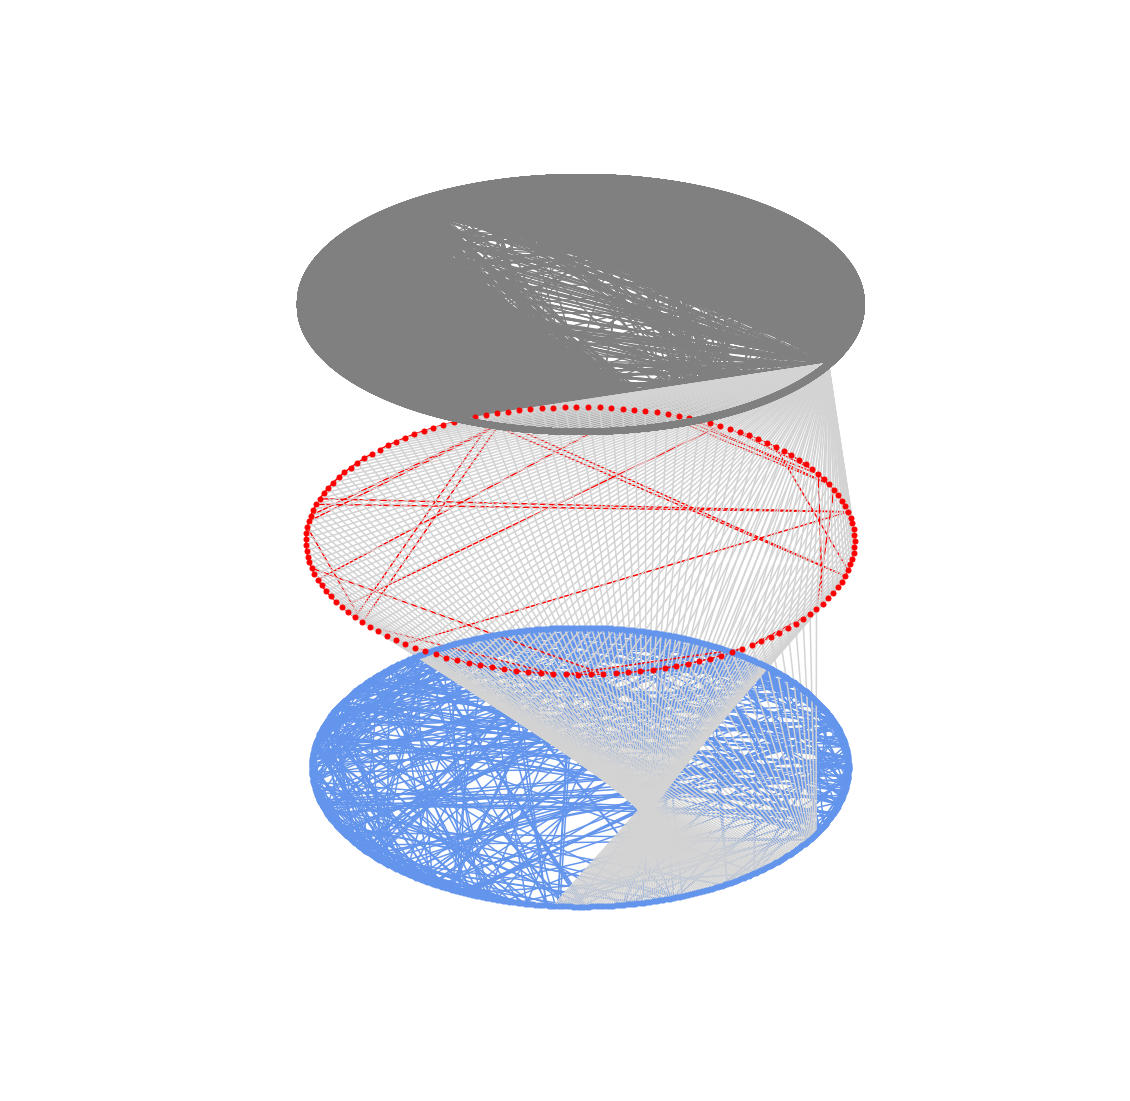

In [23]:
# Create the figure
fig = plt.figure(figsize=(20,20))
# Create 3D axes
ax = fig.add_subplot(111, projection='3d')

pos = mx.get_position3D(mg)

intra_c = ['cornflowerblue','r', "grey"]
inter_c = 'lightgrey'
layer_c = ['cornflowerblue','r', "grey"]

mg.set_edges_weights(inter_layer_edges_weight=1, intra_layer_edges_weight=1)
edge_color=[mg[a][b]['weight'] for a,b in mg.edges()]
ax.axis('off')
mx.FigureByLayer(mg, pos, ax, intra_edge_color=intra_c,node_color=layer_c, inter_edge_color=inter_c)



In [24]:
fig.tight_layout()

fig.savefig("red3d.png", dpi=300, bbox_inches='tight')